<a href="https://colab.research.google.com/github/falarion08/THESIS/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FanChiMao/SUNet.git
!pip install git+https://github.com/arsenyinfo/EnlightenGAN-inference
!pip install pytorch-msssim tensorboardX thop
!pip install ultralytics supervision -q


fatal: destination path 'SUNet' already exists and is not an empty directory.
  Cloning https://github.com/arsenyinfo/EnlightenGAN-inference to /tmp/pip-req-build-7ml_yz_k
  Running command git clone --filter=blob:none --quiet https://github.com/arsenyinfo/EnlightenGAN-inference /tmp/pip-req-build-7ml_yz_k
  Resolved https://github.com/arsenyinfo/EnlightenGAN-inference to commit 6b68a71f0b973912cffad25bff243b28530de823
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import sys
from google.colab import drive
import supervision as sv

drive.mount('/content/drive')

sys.path.insert(1, '/content/SUNet')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from SUNet import test

In [4]:
test.helper()

hello worlds


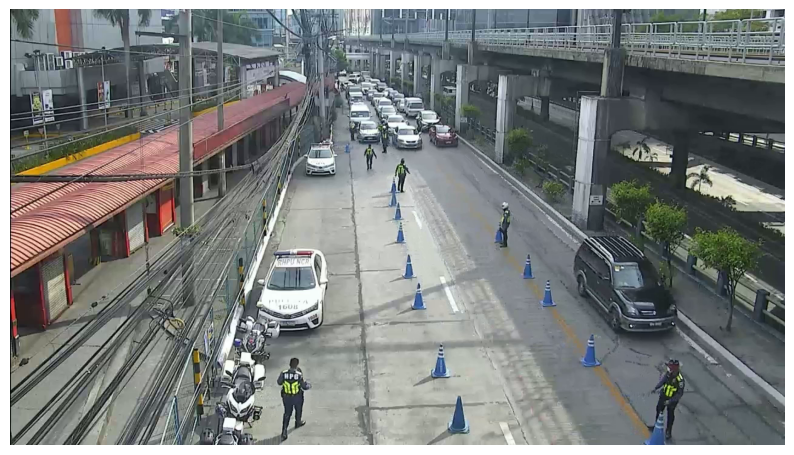

True

In [5]:
# from SUNet import demo_any_resolution
COLAB_PATH = '/content/drive/MyDrive/THESIS - RYAN BARRION/Datasets'
VIDEO_FILENAME = 'EDSA_SHAW_V3.mp4'
# Create frame generator
generator = sv.get_video_frames_generator(f'{COLAB_PATH}/{VIDEO_FILENAME}')
iterator = iter(generator)
count = 0

frame = next(iterator)

sv.plot_image(frame,(10,10))
cv2.imwrite(f'./frame.jpg', frame)

In [6]:
from enlighten_inference import EnlightenOnnxModel
import cv2

img = cv2.imread('/content/frame.jpg')

# by default, CUDAExecutionProvider is used
model = EnlightenOnnxModel()
# however, one can choose the providers priority, e.g.:
model = EnlightenOnnxModel(providers = ["CPUExecutionProvider"])

processed = model.predict(img)

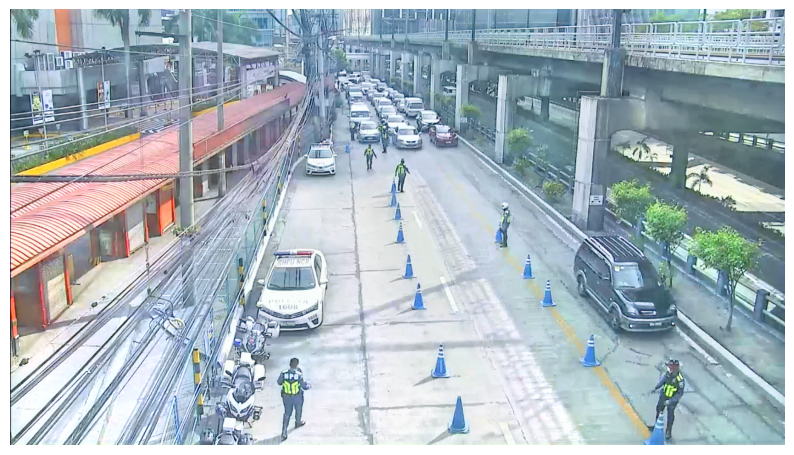

In [7]:
sv.plot_image(processed,(10,10))

In [8]:
from ultralytics import YOLO

model = YOLO('yolo11m.pt')
model.fuse() # Fuses both Conv2D and BatchNorm2D for faster Inference

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
YOLO11m summary (fused): 125 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs


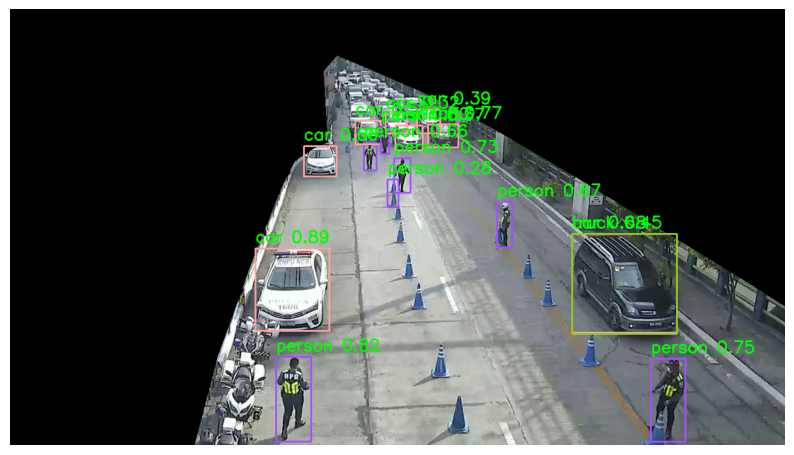

In [9]:
# from ultralytics import YOLO

# model = YOLO('yolo11m.pt')
# model.fuse() # Fuses both Conv2D and BatchNorm2D for faster Inference

#dict mapping class_id to class_name
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

#Classes of interests - person, bicycle, motorcycle, car, truck, bus
classes = [0,1,2,3,7]

# --- Define your ROAD POLYGON (from CVAT XML) ---
road_polygon = np.array([
    [305, 720],
    [343, 574],
    [405, 403],
    [447, 298],
    [470, 251],
    [502, 230],
    [525, 220],
    [518, 102],
    [540, 77],
    [601, 103],
    [673, 134],
    [733, 163],
    [800, 199],
    [936, 279],
    [1218, 452],
    [1280, 491],
    [1280, 720]
], dtype=np.int32)

# --- Create a blank mask same size as frame ---
frame_height, frame_width = frame.shape[:2]

mask = np.zeros((frame_height, frame_width), dtype=np.uint8)

# --- Fill the polygon area as white (the road region) ---
cv2.fillPoly(mask, [road_polygon], 255)

# --- Apply mask: only road area visible ---
masked_frame = cv2.bitwise_and(frame, frame, mask=mask)

# # Detect vehicles from the frame
results = model(masked_frame, iou=0.5, conf=0.2, verbose=False)[0]
# # Convert to detections
detections = sv.Detections.from_ultralytics(results)

# Only consider classes we require
detections = detections[np.isin(detections.class_id, classes)]

# create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#annotate the frame
annotated_frame = box_annotator.annotate(scene=masked_frame.copy(), detections=detections)

# format labels
labels = []

for confidence,class_id in zip(detections.confidence, detections.class_id):
  labels.append(f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}")

# overlay labels in the boundingbox
for box,label in zip(detections.xyxy,labels):
  x1, y1, x2, y2 = box.astype(int)

  # add label above the bbox
  cv2.putText(
      annotated_frame,
      label,
      (x1, y1-10),
      cv2.FONT_HERSHEY_SIMPLEX,
      fontScale=0.9, color =(0,255,0),thickness= 2)


#plot the annotated frame
sv.plot_image(annotated_frame,(10,10))

In [10]:
cv2.imwrite(f'./frame.jpg', annotated_frame)

True